# Walmart : predict weekly sales

### Description de l'entreprise

Walmart Inc. est une société multinationale américaine de vente au détail qui exploite une chaîne d'hypermarchés, de grands magasins discount et d'épiceries aux États-Unis, dont le siège est à Bentonville, Arkansas. La société a été fondée par Sam Walton en 1962.

### Projet

Le service marketing de Walmart vous a demandé de construire un modèle d'apprentissage automatique capable d'estimer les ventes hebdomadaires dans leurs magasins, avec la meilleure précision possible sur les prédictions faites. Un tel modèle les aiderait à mieux comprendre comment les ventes sont influencées par les indicateurs économiques et pourrait être utilisé pour planifier de futures campagnes marketing.

### Objectifs

Le projet peut être divisé en trois étapes :

- Partie 1 : faire une EDA et tous les prétraitements nécessaires pour préparer les données pour le machine learning
- Partie 2 : entraîner un modèle de régression linéaire (baseline)
- Partie 3 : éviter le surapprentissage en entraînant un modèle de régression régularisé

## Partie 1 : EDA et prétraitement des données

In [1]:
!pip install plotly -q

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression   #Classe pour faire de la régréssion linéaire
from sklearn.metrics import r2_score                #Classe pour faire les scores 

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "iframe" # to be replaced by "iframe" if working on JULIE

In [3]:
# Lire le fichier 
print("Loading dataset...")
dataset = pd.read_csv("Walmart_Store_sales.csv")
print("...Done.")
print()

Loading dataset...
...Done.



In [4]:
# Statistiques basiques :
print("Number of rows : {}".format(dataset.shape[0]))
print()

print("Display of dataset: ")
display(dataset.head())
print()

print("Basics statistics: ")
data_desc = dataset.describe(include='all')
display(data_desc)
print()

print("Percentage of missing values: ")
display(100*dataset.isnull().sum()/dataset.shape[0])

Number of rows : 150

Display of dataset: 


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092



Basics statistics: 


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,150.000000,132,1.360000e+02,138.000000,132.000000,136.000000,138.000000,135.000000
unique,NaN,85,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,07-01-2011,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
mean,9.866667,NaN,1.249536e+06,0.079710,61.398106,3.320853,179.898509,7.598430
std,6.231191,NaN,6.474630e+05,0.271831,18.378901,0.478149,40.274956,1.577173
min,1.000000,NaN,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000
25%,4.000000,NaN,6.050757e+05,0.000000,45.587500,2.852250,131.970831,6.597500
50%,9.000000,NaN,1.261424e+06,0.000000,62.985000,3.451000,197.908893,7.470000
75%,15.750000,NaN,1.806386e+06,0.000000,76.345000,3.706250,214.934616,8.150000



Percentage of missing values: 


Store            0.000000
Date            12.000000
Weekly_Sales     9.333333
Holiday_Flag     8.000000
Temperature     12.000000
Fuel_Price       9.333333
CPI              8.000000
Unemployment    10.000000
dtype: float64

### I - Prétraitement à prévoir avec les pandas

#### A- Supprimer les lignes où les valeurs cibles sont manquantes :

Ici, la variable cible (Y) correspond à la colonne Weekly_Sales . On peut voir ci-dessus qu'il y a des valeurs manquantes dans cette colonne.

Nous n'utilisons jamais de techniques d'imputation sur la cible : cela pourrait créer un biais dans les prédictions !

Ensuite, nous allons simplement supprimer les lignes de l'ensemble de données pour lesquelles la valeur dans Weekly_Sales est manquante.

In [5]:
# On va jeter les lignes où il y a des valeurs manquantes, dans "Weekly_Sales"
dataset = dataset.dropna(subset=['Weekly_Sales'])
dataset.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092
5,4.0,28-05-2010,1857533.70,0.0,NaN,2.756,126.160226,7.896


#### B- Créer des fonctionnalités utilisables à partir de la colonne Date 

La colonne Date ne peut pas être incluse telle quelle dans le modèle. Soit vous pouvez supprimer cette colonne, soit vous créerez de nouvelles colonnes contenant les caractéristiques numériques suivantes :

- année
- mois
- journée
- jour de la semaine

NB : se serait utile de la conserver si on veut analyser l'évolution des données dans le temps, ex : le CA ou même réutiliser ce dataset pour un forcast !

In [6]:
type(dataset['Date'])

pandas.core.series.Series

In [7]:
dataset.keys()

Index(['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment'],
      dtype='object')

In [8]:
dataset['Date'][0]

'18-02-2011'

In [9]:
from datetime import datetime

In [10]:
#Convertir la colonne "Date" dites objet en date
dataset['Date'] = pd.to_datetime(dataset['Date'])

In [11]:
#Créer une nouvelle colonne pour avoir les jours de la semaine 
dataset['day_of_week'] = dataset['Date'].dt.day_name()

In [12]:
dataset.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,day_of_week
0,6.0,2011-02-18,1572117.54,NaN,59.61,3.045,214.777523,6.858,Friday
1,13.0,2011-03-25,1807545.43,0.0,42.38,3.435,128.616064,7.470,Friday
3,11.0,NaT,1244390.03,0.0,84.57,NaN,214.556497,7.346,NaN
4,6.0,2010-05-28,1644470.66,0.0,78.89,2.759,212.412888,7.092,Friday
5,4.0,2010-05-28,1857533.70,0.0,NaN,2.756,126.160226,7.896,Friday


#### a - Fractionner la colonne "Date" en plusieurs colonnes (jour, mois et année)

In [13]:
#On voit que la conversion à bien était faite
dataset.dtypes

Store                  float64
Date            datetime64[ns]
Weekly_Sales           float64
Holiday_Flag           float64
Temperature            float64
Fuel_Price             float64
CPI                    float64
Unemployment           float64
day_of_week             object
dtype: object

In [14]:
#Ajout de la colonne "Month"
dataset['month'] = dataset['Date'].dt.month

In [15]:
#Ajout de la colonne "Day"
dataset['day'] = dataset['Date'].dt.day

In [16]:
#Ajout de la colonne "Year"
dataset['year'] = dataset['Date'].dt.year

In [17]:
dataset.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,day_of_week,month,day,year
0,6.0,2011-02-18,1572117.54,NaN,59.61,3.045,214.777523,6.858,Friday,2.0,18.0,2011.0
1,13.0,2011-03-25,1807545.43,0.0,42.38,3.435,128.616064,7.470,Friday,3.0,25.0,2011.0
3,11.0,NaT,1244390.03,0.0,84.57,NaN,214.556497,7.346,NaN,NaN,NaN,NaN
4,6.0,2010-05-28,1644470.66,0.0,78.89,2.759,212.412888,7.092,Friday,5.0,28.0,2010.0
5,4.0,2010-05-28,1857533.70,0.0,NaN,2.756,126.160226,7.896,Friday,5.0,28.0,2010.0


In [18]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136 entries, 0 to 149
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         136 non-null    float64       
 1   Date          118 non-null    datetime64[ns]
 2   Weekly_Sales  136 non-null    float64       
 3   Holiday_Flag  125 non-null    float64       
 4   Temperature   121 non-null    float64       
 5   Fuel_Price    124 non-null    float64       
 6   CPI           125 non-null    float64       
 7   Unemployment  122 non-null    float64       
 8   day_of_week   118 non-null    object        
 9   month         118 non-null    float64       
 10  day           118 non-null    float64       
 11  year          118 non-null    float64       
dtypes: datetime64[ns](1), float64(10), object(1)
memory usage: 18.8+ KB


#### b - vérifier les valeurs :

In [20]:
dataset["day"].unique()  

array([18., 25., nan, 28.,  6.,  2., 12., 19., 15., 13., 16., 10., 30.,
       20.,  4., 26.,  5., 23., 24., 11., 27., 14.,  7.,  8., 17.,  3.,
        1., 22., 31., 29.,  9.])

In [21]:
dataset["month"].unique()  

array([ 2.,  3., nan,  5., 10.,  8.,  1.,  4., 12.,  6.,  9., 11.,  7.])

In [22]:
dataset["year"].unique()  

array([2011.,   nan, 2010., 2012.])

In [23]:
dataset["day_of_week"].unique()

array(['Friday', nan, 'Sunday', 'Tuesday', 'Thursday', 'Monday',
       'Saturday'], dtype=object)

##### On constate qu'il n'y a pas de valeurs abérentes... Mais on a des valeurs manquantes ! 

##### On va supprimer les lignes où on voit des dates manquantes, pour les raisons suivantes : 
- On ne peut pas soliciter le client, pour connaitre une date approximative
- Ensuite, on n'a un trop gros écart entre la date précédante et la suivante, donc on ne peut pas faire une moyenne de la date.
- Recommandation : c'est important d'avoir la date, pour éviter de perdre des données (ex : CA), pour avoir un résultat exacte en ce qui concerne les performances des magasins.  

In [24]:
# On va jeter les lignes où il y a des valeurs manquantes, dans "Date"
dataset = dataset.dropna(subset=['Date'])
dataset.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,day_of_week,month,day,year
0,6.0,2011-02-18,1572117.54,NaN,59.61,3.045,214.777523,6.858,Friday,2.0,18.0,2011.0
1,13.0,2011-03-25,1807545.43,0.0,42.38,3.435,128.616064,7.470,Friday,3.0,25.0,2011.0
4,6.0,2010-05-28,1644470.66,0.0,78.89,2.759,212.412888,7.092,Friday,5.0,28.0,2010.0
5,4.0,2010-05-28,1857533.70,0.0,NaN,2.756,126.160226,7.896,Friday,5.0,28.0,2010.0
6,15.0,2011-03-06,695396.19,0.0,69.80,4.069,134.855161,7.658,Sunday,3.0,6.0,2011.0


#### C - Supprimer les lignes contenant des valeurs invalides ou des valeurs aberrantes (Température , Fuel_price , CPI et Unemployment) :

In [25]:
#Voir les valeurs manquantes des colonnes Température , Fuel_price , CPI et Unemployment :
print("Percentage of missing values: ")
display(100*dataset.isnull().sum()/dataset.shape[0])

Percentage of missing values: 


Store           0.000000
Date            0.000000
Weekly_Sales    0.000000
Holiday_Flag    7.627119
Temperature     9.322034
Fuel_Price      9.322034
CPI             7.627119
Unemployment    9.322034
day_of_week     0.000000
month           0.000000
day             0.000000
year            0.000000
dtype: float64

In [26]:
dataset = dataset.dropna(subset=['Temperature', 'Fuel_Price','CPI','Unemployment'])
dataset.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,day_of_week,month,day,year
0,6.0,2011-02-18,1572117.54,NaN,59.61,3.045,214.777523,6.858,Friday,2.0,18.0,2011.0
1,13.0,2011-03-25,1807545.43,0.0,42.38,3.435,128.616064,7.470,Friday,3.0,25.0,2011.0
4,6.0,2010-05-28,1644470.66,0.0,78.89,2.759,212.412888,7.092,Friday,5.0,28.0,2010.0
6,15.0,2011-03-06,695396.19,0.0,69.80,4.069,134.855161,7.658,Sunday,3.0,6.0,2011.0
7,20.0,2012-03-02,2203523.20,0.0,39.93,3.617,213.023623,6.961,Friday,3.0,2.0,2012.0


In [27]:
print("Percentage of missing values: ")
display(100*dataset.isnull().sum()/dataset.shape[0])

Percentage of missing values: 


Store            0.000000
Date             0.000000
Weekly_Sales     0.000000
Holiday_Flag    10.714286
Temperature      0.000000
Fuel_Price       0.000000
CPI              0.000000
Unemployment     0.000000
day_of_week      0.000000
month            0.000000
day              0.000000
year             0.000000
dtype: float64

##### a - Faire des visualisations pour identifier les outlyers (ou valeurs aberrantes)

Graphiques avec Seaborn

In [28]:
import seaborn as sns

<AxesSubplot:xlabel='Unemployment'>

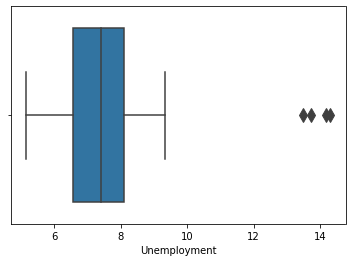

In [29]:
#Graphique pour la colonne "Unemployment" :
sns.boxplot(x=dataset['Unemployment'], fliersize=10)     

<AxesSubplot:xlabel='Temperature'>

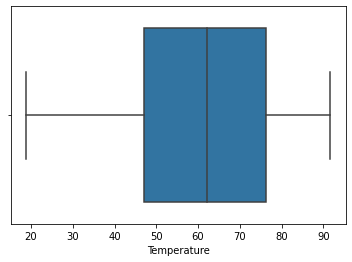

In [30]:
#Graphique pour la colonne "Temperature" :
sns.boxplot(x=dataset['Temperature'], fliersize=10)

<AxesSubplot:xlabel='CPI'>

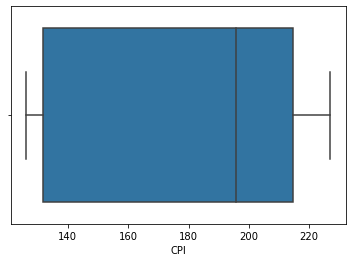

In [31]:
#Graphique pour la colonne "CPI" :
sns.boxplot(x=dataset['CPI'], fliersize=10)

<AxesSubplot:xlabel='Fuel_Price'>

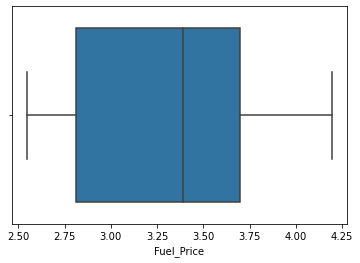

In [32]:
#Graphique pour la colonne "CPI" :
sns.boxplot(x=dataset['Fuel_Price'], fliersize=10)

NB : On constate la présence d'outliers uniquement dans la colonne "Unemployment"

##### b - Supprimer les outliers de la colonne "Unemployment"

In [33]:
print('Dropping outliers in Unemployment...')
to_keep = dataset['Unemployment'] < dataset['Unemployment'].mean() + 3*dataset['Unemployment'].std()   #On ne veut pas garder les données 3 écartypes de la moyenne 
dataset = dataset.loc[to_keep,:]
print('Done. Number of lines remaining : ', dataset.shape[0])
print()

dataset.head()

Dropping outliers in Unemployment...
Done. Number of lines remaining :  80



,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,day_of_week,month,day,year
0,6.0,2011-02-18,1572117.54,NaN,59.61,3.045,214.777523,6.858,Friday,2.0,18.0,2011.0
1,13.0,2011-03-25,1807545.43,0.0,42.38,3.435,128.616064,7.470,Friday,3.0,25.0,2011.0
4,6.0,2010-05-28,1644470.66,0.0,78.89,2.759,212.412888,7.092,Friday,5.0,28.0,2010.0
6,15.0,2011-03-06,695396.19,0.0,69.80,4.069,134.855161,7.658,Sunday,3.0,6.0,2011.0
7,20.0,2012-03-02,2203523.20,0.0,39.93,3.617,213.023623,6.961,Friday,3.0,2.0,2012.0


In [34]:
#Pour contrôler les données : 
dataset.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,month,day,year
count,80.000000,8.000000e+01,71.000000,80.00000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000
mean,9.575000,1.221522e+06,0.084507,61.12775,3.290700,181.077638,7.301775,6.525000,15.962500,2010.887500
std,6.143382,6.799270e+05,0.280126,17.44760,0.491223,38.847021,0.955392,3.329861,8.594145,0.826672
min,1.000000,2.689290e+05,0.000000,18.79000,2.548000,126.139200,5.143000,1.000000,1.000000,2010.000000
25%,4.000000,5.295107e+05,0.000000,45.58750,2.804000,132.610242,6.520750,4.000000,8.000000,2010.000000
50%,8.000000,1.260826e+06,0.000000,61.45000,3.390500,197.500965,7.345500,6.000000,16.500000,2011.000000
75%,15.000000,1.817517e+06,0.000000,75.47750,3.689750,214.809008,8.090000,9.250000,23.250000,2012.000000
max,20.000000,2.771397e+06,1.000000,91.65000,4.170000,226.968844,9.342000,12.000000,31.000000,2012.000000


<AxesSubplot:xlabel='Unemployment'>

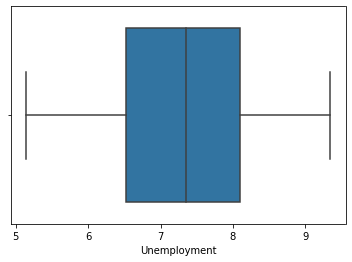

In [35]:
#Graphique pour contrôler la suppression des outliers dans la colonne "Unemployment" :
sns.boxplot(x=dataset['Unemployment'], fliersize=10)  

### II - Entraîner un modèle de régression linéaire (baseline)

#### I - Préparation du modèle avec Pandas:

In [36]:
dataset.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,day_of_week,month,day,year
0,6.0,2011-02-18,1572117.54,NaN,59.61,3.045,214.777523,6.858,Friday,2.0,18.0,2011.0
1,13.0,2011-03-25,1807545.43,0.0,42.38,3.435,128.616064,7.470,Friday,3.0,25.0,2011.0
4,6.0,2010-05-28,1644470.66,0.0,78.89,2.759,212.412888,7.092,Friday,5.0,28.0,2010.0
6,15.0,2011-03-06,695396.19,0.0,69.80,4.069,134.855161,7.658,Sunday,3.0,6.0,2011.0
7,20.0,2012-03-02,2203523.20,0.0,39.93,3.617,213.023623,6.961,Friday,3.0,2.0,2012.0


In [37]:
# Drop useless columns / columns with too many missing values
useless_cols = ['Date']

print("Dropping useless columns...")
dataset = dataset.drop(useless_cols, axis=1) # axis = 1 indicates that we are dropping along the column axis   + inplace = True : permet de ne pas reassigné à dataset
# never hesitate to look at a function's documentation using the command name_of_the_function?
print("...Done.")
print(dataset.head())

Dropping useless columns...
...Done.
   Store  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price         CPI  \
0    6.0    1572117.54           NaN        59.61       3.045  214.777523   
1   13.0    1807545.43           0.0        42.38       3.435  128.616064   
4    6.0    1644470.66           0.0        78.89       2.759  212.412888   
6   15.0     695396.19           0.0        69.80       4.069  134.855161   
7   20.0    2203523.20           0.0        39.93       3.617  213.023623   

   Unemployment day_of_week  month   day    year  
0         6.858      Friday    2.0  18.0  2011.0  
1         7.470      Friday    3.0  25.0  2011.0  
4         7.092      Friday    5.0  28.0  2010.0  
6         7.658      Sunday    3.0   6.0  2011.0  
7         6.961      Friday    3.0   2.0  2012.0  


In [38]:
# Separate target variable Y from features X
target_name = 'Weekly_Sales'

print("Separating labels from features...")
Y = dataset.loc[:,target_name]
X = dataset.loc[:,[c for c in dataset.columns if c!=target_name]] # On garde toutes les colonnes excepté la target
print("...Done.")
print(Y.head())
print()
print(X.head())
print()

Separating labels from features...
...Done.
0    1572117.54
1    1807545.43
4    1644470.66
6     695396.19
7    2203523.20
Name: Weekly_Sales, dtype: float64

   Store  Holiday_Flag  Temperature  Fuel_Price         CPI  Unemployment  \
0    6.0           NaN        59.61       3.045  214.777523         6.858   
1   13.0           0.0        42.38       3.435  128.616064         7.470   
4    6.0           0.0        78.89       2.759  212.412888         7.092   
6   15.0           0.0        69.80       4.069  134.855161         7.658   
7   20.0           0.0        39.93       3.617  213.023623         6.961   

  day_of_week  month   day    year  
0      Friday    2.0  18.0  2011.0  
1      Friday    3.0  25.0  2011.0  
4      Friday    5.0  28.0  2010.0  
6      Sunday    3.0   6.0  2011.0  
7      Friday    3.0   2.0  2012.0  



In [39]:
# On doit convertir nos données en numpy avant l'utilisation de scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X = X.values
Y = Y.tolist()    
print("...Done")
print(X[0:5,:])
print()
print(Y[0:5])

Convert pandas DataFrames to numpy arrays...
...Done
[[6.0 nan 59.61 3.045 214.77752310000002 6.858 'Friday' 2.0 18.0 2011.0]
 [13.0 0.0 42.38 3.435 128.6160645 7.47 'Friday' 3.0 25.0 2011.0]
 [6.0 0.0 78.89 2.759 212.41288799999998 7.0920000000000005 'Friday' 5.0
  28.0 2010.0]
 [15.0 0.0 69.8 4.069 134.85516130000002 7.657999999999999 'Sunday' 3.0
  6.0 2011.0]
 [20.0 0.0 39.93 3.617 213.02362250000002 6.961 'Friday' 3.0 2.0 2012.0]]

[1572117.54, 1807545.43, 1644470.66, 695396.19, 2203523.2]


In [40]:
X

array([[6.0, nan, 59.61, 3.045, 214.77752310000002, 6.858, 'Friday', 2.0,
        18.0, 2011.0],
       [13.0, 0.0, 42.38, 3.435, 128.6160645, 7.47, 'Friday', 3.0, 25.0,
        2011.0],
       [6.0, 0.0, 78.89, 2.759, 212.41288799999998, 7.0920000000000005,
        'Friday', 5.0, 28.0, 2010.0],
       [15.0, 0.0, 69.8, 4.069, 134.85516130000002, 7.657999999999999,
        'Sunday', 3.0, 6.0, 2011.0],
       [20.0, 0.0, 39.93, 3.617, 213.02362250000002, 6.961, 'Friday',
        3.0, 2.0, 2012.0],
       [8.0, 0.0, 82.92, 3.554, 219.07019680000005, 6.425, 'Friday', 8.0,
        19.0, 2011.0],
       [18.0, 0.0, 52.02, 2.878, 132.7633548, 9.331, 'Friday', 10.0,
        15.0, 2010.0],
       [7.0, 0.0, 36.61, 3.767, 192.826069, 8.595, 'Friday', 5.0, 13.0,
        2011.0],
       [1.0, 0.0, 64.74, 3.734, 221.21181319999997, 7.348, 'Friday', 3.0,
        16.0, 2012.0],
       [17.0, 0.0, 60.07, 2.853, 126.2346, 6.885, 'Sunday', 1.0, 10.0,
        2010.0],
       [6.0, nan, 68.91, 2.78, 211.

In [41]:
Y

[1572117.54,
 1807545.43,
 1644470.66,
 695396.19,
 2203523.2,
 895066.5,
 1029618.1,
 414094.05,
 1677472.78,
 829207.27,
 1498080.16,
 561145.14,
 290930.01,
 1074079.0,
 1427023.45,
 1405007.44,
 919878.34,
 435397.19,
 757738.76,
 563460.77,
 1266564.94,
 365248.94,
 2008344.92,
 311906.7,
 961186.23,
 629994.47,
 1641957.44,
 1861802.7,
 268929.03,
 1549018.68,
 1624383.75,
 485095.41,
 2035431.39,
 1916812.74,
 1879451.23,
 1805999.79,
 1847430.96,
 888816.78,
 2020550.99,
 1990371.02,
 313358.15,
 2771397.17,
 1166117.85,
 461622.22,
 2461468.35,
 1449142.92,
 1973135.87,
 570611.23,
 1539483.7,
 519823.3,
 1758050.79,
 431985.36,
 485389.15,
 1953544.76,
 1494251.5,
 2018314.71,
 364076.85,
 2302504.86,
 419497.95,
 1366395.96,
 994801.4,
 1799737.79,
 1757242.51,
 457340.06,
 513073.87,
 836707.85,
 275142.17,
 597876.55,
 398838.97,
 614253.33,
 1970341.38,
 2025582.62,
 2036231.39,
 2066541.86,
 1639358.93,
 532739.77,
 396968.8,
 424513.08,
 2248645.59,
 1255087.26]

#### II - Préparation du modèle avec scikit_learn :

In [42]:
# En 1er : il faut diviser le jeux de données dans un train set et test set !!
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)  #On a mis 80% des données dans le train et 20% dans le test

print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [43]:
X_train.shape, X_test.shape

((64, 10), (16, 10))

##### A - Transformer les variables numériques : Température, Fuel_Price, CPI, Chômage, Année, Mois, Jour

In [44]:
from sklearn.pipeline import Pipeline

In [45]:
# Convertir les variables numériques : 
numeric_features = [2,3,4,5,7,8,9] # Positions des colonnes 
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())   #La on procède à la standardisation c'est à dire remplace les données par 0 ou 1
])

##### B - Transformer les variables catégorielles : Store, Holiday_Flag, day_of_week 

In [46]:
dataset['Store'].unique()  #Les différents magasins

array([ 6., 13., 15., 20.,  8., 18.,  7.,  1., 17.,  5., 19., 16.,  3.,
        4.,  2., 14., 10.,  9., 11.])

In [47]:
# Convertir les variables catégorielles : 
categorical_features = [0,1,6] # Positions des colonnes
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), #Remplacer les valeurs manquantes par les données les plus fréquentes
    ('encoder', OneHotEncoder(drop='first')) # En cas de OneHotEncoder, on jete la 1ère colonnes pour éviter une correlations entre nos variables
    ])

In [48]:
# On utilise columnTransformer (qui est un wrapper) pour appliquer les pipelines sur les données catégoriel et numérique 
preprocessor = ColumnTransformer(        
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [49]:
# Preprocessings on train set
print("Performing preprocessings on train set...")
print(X_train[0:5,:])
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[0:5,:])
print()

# Preprocessings on test set
print("Performing preprocessings on test set...")  
print(X_test[0:5,:])
X_test = preprocessor.transform(X_test) 
print('...Done.')
print(X_test[0:5,:])
print()

Performing preprocessings on train set...
[[15.0 0.0 69.8 4.069 134.85516130000002 7.657999999999999 'Sunday' 3.0
  6.0 2011.0]
 [4.0 0.0 81.85 3.57 129.0663 5.9460000000000015 'Friday' 6.0 24.0 2011.0]
 [7.0 0.0 36.61 3.767 192.826069 8.595 'Friday' 5.0 13.0 2011.0]
 [1.0 1.0 38.51 2.548 211.24216980000003 8.106 'Thursday' 12.0 2.0 2010.0]
 [18.0 0.0 73.67 2.792 132.6141935 9.342 'Tuesday' 6.0 8.0 2010.0]]
...Done.
  (0, 0)	0.5858922363885097
  (0, 1)	1.5619981885198218
  (0, 2)	-1.0553617637599562
  (0, 3)	0.30814093975278123
  (0, 4)	-1.0065907243997732
  (0, 5)	-1.1021828439525225
  (0, 6)	0.18751465015433733
  (0, 19)	1.0
  (0, 28)	1.0
  (1, 0)	1.2843080223114072
  (1, 1)	0.5704464950143056
  (1, 2)	-1.2039825405701505
  (1, 3)	-1.5030487221126148
  (1, 4)	-0.12410022629586245
  (1, 5)	0.9965190341190575
  (1, 6)	0.18751465015433733
  (1, 9)	1.0
  (2, 0)	-1.3377940652530642
  (2, 1)	0.9619007708070645
  (2, 2)	0.4329588036659842
  (2, 3)	1.2994287395003763
  (2, 4)	-0.418263725663

#### III - Entrainement du modèle :

In [51]:
# Train model
print("Train model...")
regressor = LinearRegression()
regressor.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


#### IV - Prédiction du modèle :

In [52]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = regressor.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[ 666652.75430817 2086010.59275823  491914.70774259 1587905.61632527
 1151280.54794089 2116637.00892221 2468460.05334645 1232917.25294037
 1967866.28523053  458384.849185    951008.36964463 1757242.50962973
 1093556.09482814  306573.45848501 2219380.52618065 2176435.94586609
 1916812.74027334 2010493.57114034  214769.8877637   617011.3368659
 2374937.63906467  469275.50987785 1562699.81589784  462107.75111135
  460574.6828444  1872900.11616421 1907149.7266863  2018401.1479049
  507168.50234373 1437749.44858684 1551118.65115373  673805.46791148
 1514216.70443607  560310.06800535  886835.93529263 1892712.33570788
  860770.437813   1588618.06324819 2095610.76010077 1315187.42921866
  807920.24345484 1421661.0724425   854643.9538724   557632.31663516
 1347365.82085266 1558238.75065213 1674657.45158312 1099328.60356336
  497196.3563925   901499.88989665 1927060.798211   1903658.47267764
  954964.02474685  437514.04474157  187720.34261474 2015427.49599

In [53]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = regressor.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[1629212.6198693  1792031.29010023 1481096.74433707  628148.86718642
 1568385.0293894  2010057.72450204   86284.93800311  471551.11158755
 1734588.56802091  684078.07384475  563327.08639701  546428.43337153
 1579246.56208506 2133707.03847517  624026.80214543 2009083.69046768]



In [54]:
# Print R^2 scores
print("R2 score on training set : ", r2_score(Y_train, Y_train_pred))
print("R2 score on test set : ", r2_score(Y_test, Y_test_pred))

R2 score on training set :  0.9833988407619012
R2 score on test set :  0.9593306758258291


En conclusion : On constate que le train et le test sont proches du 100% ! Et on constate également pas d'overfiting car les score du train et du test sont relativement proches. Dans notre cas, il n'est pas nécéssaire d'utiliser des hyperparamètres pour empêcher le modèle d'overfiter. 